In [1]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch


/software/ys20884/miniconda3/envs/chip_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Dataset(1_000, (120, 72), signal_file="CaloImages_signal.root", pile_up_file="CaloImages_bkg.root")

In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file CaloImages_signal.root
loading file CaloImages_signal.root
100%|██████████| 1000/1000 [00:01<00:00, 543.92it/s]
INFO:root:loading file CaloImages_bkg.root
loading file CaloImages_bkg.root
100%|██████████| 1000/1000 [00:01<00:00, 531.32it/s]


In [2]:
new_dim=(64,64)

In [26]:
dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling
INFO:root:re-sizing
re-sizing


In [27]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [28]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [21]:
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([1]) #each unit of timestep represents an addtional 5 pile-up events
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[0], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)


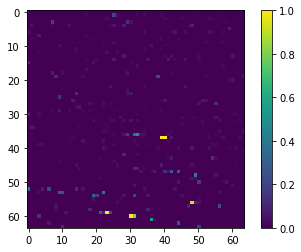

In [29]:
plt.imshow(noisy_image.reshape(new_dim))
plt.colorbar()

In [3]:
from models import Model

model = Model('UNet', new_dim)

In [5]:
model.__getitem__()

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
    

In [18]:
trained_model_path = 'trained_models/trained_diffusor.pt'

In [19]:
checkpoint = torch.load(trained_model_path)

In [20]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [22]:
noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0]

In [23]:
de_noised = noisy_image[0] - (noise_pred.detach().numpy().reshape(new_dim))

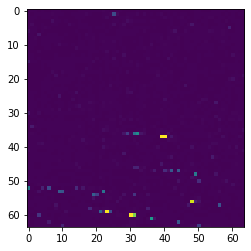

In [24]:
plt.imshow(de_noised.reshape(new_dim))